# Comparison of two algorithms

We will see in this notebook how we can compare the prediction accuracy of two algorithms.

In [1]:
from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      
import pickle
import os

import pandas as pd

from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise import dump
from surprise.accuracy import rmse

In [16]:
# We will train and test on the u1.base and u1.test files of the movielens-100k dataset.
# if you haven't already, you need to download the movielens-100k dataset
# You can do it manually, or by running:

#Dataset.load_builtin('ml-100k')

# Now, let's load the dataset
train_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.base'
test_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.test'
data = Dataset.load_from_folds([(train_file, test_file)], Reader('ml-100k'))

                
# We'll use the well-known SVD algorithm and a basic nearest neighbors approach.
algo_svd = SVD()                                                       
algo_knn = KNNBasic()

for trainset, testset in data.folds(): 
    algo_svd.train(trainset)                             
    predictions_svd = algo_svd.test(testset)
    
    algo_knn.train(trainset)
    predictions_knn = algo_knn.test(testset)
    
    rmse(predictions_svd)
    rmse(predictions_knn)                                                                           
    
    dump('./dump_SVD', predictions_svd, trainset, algo_svd)
    dump('./dump_KNN', predictions_knn, trainset, algo_knn)

Computing the msd similarity matrix...
RMSE: 0.9525
RMSE: 0.9889
The dump has been saved as file ./dump_SVD
The dump has been saved as file ./dump_KNN


In [6]:
# The dumps have been saved and we can now use them whenever we want.

dump_obj_svd = pickle.load(open('./dump_SVD', 'rb'))
dump_obj_knn = pickle.load(open('./dump_KNN', 'rb'))

df_svd = pd.DataFrame(dump_obj_svd['predictions'], columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn = pd.DataFrame(dump_obj_knn['predictions'], columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd['err'] = abs(df_svd.est - df_svd.rui)
df_knn['err'] = abs(df_knn.est - df_knn.rui)

We now have two dataframes with the all the predictions for each algorithm. The cool thing is that, as both algorithm have been tested on the same testset, the indexes of the two dataframes are the same!

In [17]:
df_svd.head()

,uid,iid,rui,est,details,err
0,1,6,5.0,3.796291,{'was_impossible': False},1.203709
1,1,10,3.0,3.955134,{'was_impossible': False},0.955134
2,1,12,5.0,4.477002,{'was_impossible': False},0.522998
3,1,14,5.0,3.990782,{'was_impossible': False},1.009218
4,1,17,3.0,3.376097,{'was_impossible': False},0.376097


In [18]:
df_knn.head()

,uid,iid,rui,est,details,err
0,1,6,5.0,3.468613,"{'was_impossible': False, 'actual_k': 20}",1.531387
1,1,10,3.0,3.866290,"{'was_impossible': False, 'actual_k': 40}",0.866290
2,1,12,5.0,4.538194,"{'was_impossible': False, 'actual_k': 40}",0.461806
3,1,14,5.0,4.235741,"{'was_impossible': False, 'actual_k': 40}",0.764259
4,1,17,3.0,3.228002,"{'was_impossible': False, 'actual_k': 40}",0.228002


In [38]:
# Let's check how good are the KNN predictions when the SVD has a huge error:
df_knn[df_svd.err >= 3.5]

,uid,iid,rui,est,details,err
1905,38,211,1.0,4.136955,"{'was_impossible': False, 'actual_k': 40}",3.136955
1925,38,432,1.0,4.064878,"{'was_impossible': False, 'actual_k': 40}",3.064878
1930,38,526,1.0,4.115078,"{'was_impossible': False, 'actual_k': 40}",3.115078
5024,99,694,1.0,4.078664,"{'was_impossible': False, 'actual_k': 36}",3.078664
7390,167,169,1.0,4.664991,"{'was_impossible': False, 'actual_k': 40}",3.664991
13972,295,183,1.0,4.202611,"{'was_impossible': False, 'actual_k': 40}",3.202611
15306,312,265,1.0,4.131875,"{'was_impossible': False, 'actual_k': 40}",3.131875
19096,405,192,5.0,3.763118,"{'was_impossible': False, 'actual_k': 40}",1.236882
19155,405,673,5.0,3.433994,"{'was_impossible': False, 'actual_k': 40}",1.566006


In [39]:
# Well... Not much better.
# Now, let's look at the predictions of SVD on the 10 worst predictions for KNN
df_svd.iloc[df_knn.sort_values(by='err')[-10:].index]

,uid,iid,rui,est,details,err
9406,208,302,1.0,4.386044,{'was_impossible': False},3.386044
19089,405,169,1.0,2.087386,{'was_impossible': False},1.087386
19785,436,132,1.0,4.389942,{'was_impossible': False},3.389942
157,2,315,1.0,4.176330,{'was_impossible': False},3.176330
8503,193,56,1.0,3.893228,{'was_impossible': False},2.893228
5531,113,976,5.0,2.924792,{'was_impossible': False},2.075208
7917,181,408,1.0,1.976466,{'was_impossible': False},0.976466
7390,167,169,1.0,4.738044,{'was_impossible': False},3.738044
7412,167,1306,5.0,3.942998,{'was_impossible': False},1.057002
5553,114,1104,5.0,3.338453,{'was_impossible': False},1.661547


<IPython.core.display.Javascript object>


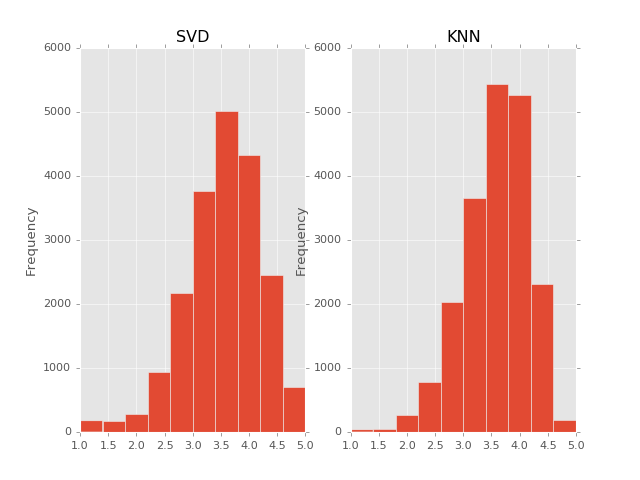

In [47]:
# How different are the predictions from both algorithms ?
# Let's count the number of predictions for each rating value

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

figure, (ax1, ax2) = plt.subplots(1, 2)

df_svd.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [55]:
# Question: when a user have rated only a small number of items (less than 10), which algorithm
# gives the best predictions on average?

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
df_knn['Iu'] = df_knn.uid.apply(get_Iu)
df_svd['Iu'] = df_svd.uid.apply(get_Iu)

df_knn[df_knn.Iu < 10].err.mean(), df_svd[df_svd.Iu < 10].err.mean()
# Answer: SVD, by far!

(1.0382962702232326, 0.98011188976827956)